In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../..')

from utils.workflow import WorkflowModel
import utils.plotting as plotting
from utils.eval import eval_predictions

2025-12-13 08:10:51.148090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:
df = pd.read_csv("../../data/influenza_england_1978_school.csv")
df.shape

(14, 3)

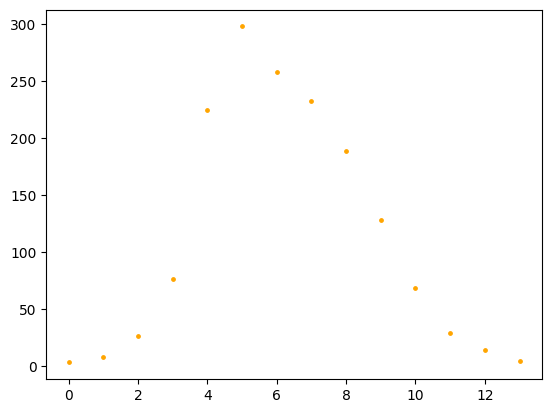

In [3]:
I_data = df["in_bed"].to_numpy()
plt.scatter(np.linspace(0, 13, len(I_data)), I_data, label="Dados I", color="orange", s=6)
plt.show()

In [4]:
I_data = df["in_bed"].to_numpy()

def double_data(data, times):
    if times <= 0: return data
    avg_arr = ((data + np.roll(data, -1))/2.0)
    return double_data(np.vstack([data, avg_arr]).flatten('F')[:-1], times - 1)

# I_data = double_data(I_data, 3)
I_data.shape

(14,)

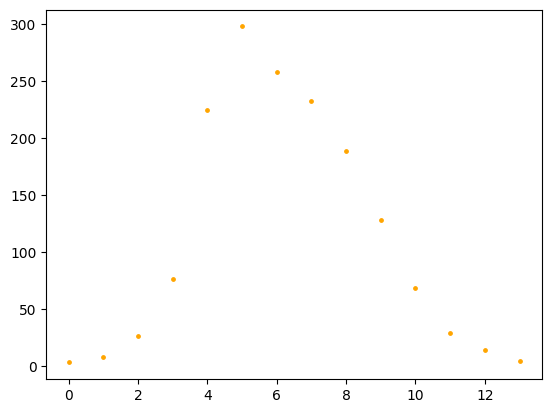

In [5]:
plt.scatter(np.linspace(0, 13, len(I_data)), I_data, label="Dados I", color="orange", s=6)
plt.show()

In [6]:
t_0, t_f = 0, 13
N = 763
gamma = 0.457
data_t = np.linspace(t_0, t_f, len(I_data))
model = WorkflowModel(t_0, t_f, I_data, data_t, N, gamma, scaling="min/max")

[<deepxde.icbc.initial_conditions.IC object at 0x7f5430b789d0>, <deepxde.icbc.initial_conditions.IC object at 0x7f544e3ba4d0>, <deepxde.icbc.initial_conditions.IC object at 0x7f54c3415110>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x7f5430b9b750>]
Compiling model...
'compile' took 0.008809 s



2025-12-13 08:10:54.950591: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1765624254.951342  676766 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2249 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [7]:
model.S0, model.I0, model.R0 

(np.float64(2.5762711864406778),
 np.float64(0.0),
 np.float64(-0.010169491525423728))

In [8]:
model.train()

Training model...



2025-12-13 08:10:56.944850: I external/local_xla/xla/service/service.cc:163] XLA service 0x55c2ea9b8f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-13 08:10:56.944869: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-12-13 08:10:56.961651: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-13 08:10:57.057693: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1765624257.366726  676766 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.42e-04, 1.38e-01, 9.66e-02, 3.42e+00, 6.64e+00, 0.00e+00, 1.03e-04, 1.66e-01]    [2.02e-04, 1.36e-01, 1.04e-01, 3.19e+00, 6.64e+00, 0.00e+00, 1.03e-04, 1.66e-01]    []  
100       [7.33e-03, 7.66e-03, 1.14e-02, 1.63e-03, 9.87e-05, 2.35e-06, 3.83e-05, 7.59e-02]    [8.07e-03, 7.41e-03, 1.26e-02, 1.41e-03, 9.87e-05, 2.35e-06, 3.83e-05, 7.59e-02]    []  
200       [3.12e-03, 2.78e-03, 4.12e-03, 8.81e-04, 5.17e-06, 6.23e-07, 6.79e-06, 3.25e-02]    [3.17e-03, 2.86e-03, 4.53e-03, 8.17e-04, 5.17e-06, 6.23e-07, 6.79e-06, 3.25e-02]    []  
300       [2.76e-03, 2.15e-03, 1.52e-03, 2.71e-04, 6.21e-06, 8.99e-07, 2.94e-08, 1.45e-02]    [2.29e-03, 2.13e-03, 1.40e-03, 3.00e-04, 6.21e-06, 8.99e-07, 2.94e-08, 1.45e-02]    []  
400       [2.16e-03, 1.61e-03, 1.07e-03, 2.76e-04, 4.11e-06, 5.65e-07, 4.48e-0

(<deepxde.model.LossHistory at 0x7f556a453410>,
 <deepxde.model.TrainState at 0x7f5430b9b4d0>)

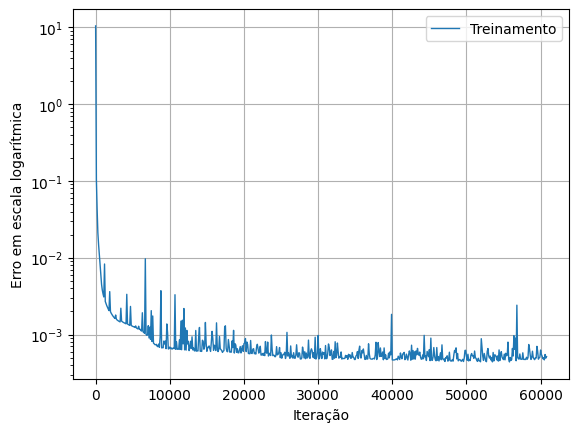

In [9]:
plotting.plot_losshistory(model.losshistory)

In [10]:
test_t = np.linspace(t_0, t_f, 50)
pred = model.predict(test_t.reshape(-1, 1))

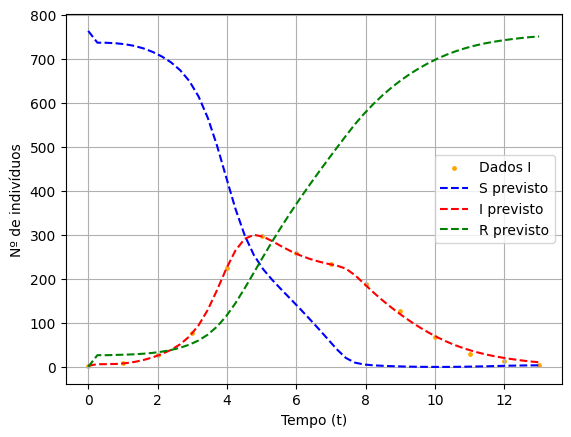

In [11]:
S_pred = pred[:,0]
I_pred = pred[:,1]
R_pred = pred[:,2]

plt.scatter(data_t, I_data, label="Dados I", color="orange", s=6)

plt.plot(test_t, S_pred, label="S previsto", linestyle="--", color="blue")
plt.plot(test_t, I_pred, label="I previsto", linestyle="--", color="red")
plt.plot(test_t, R_pred, label="R previsto", linestyle="--", color="green")

plt.xlabel("Tempo (t)")
plt.ylabel("Nº de indivíduos")

plt.legend()
plt.grid()

plt.show()

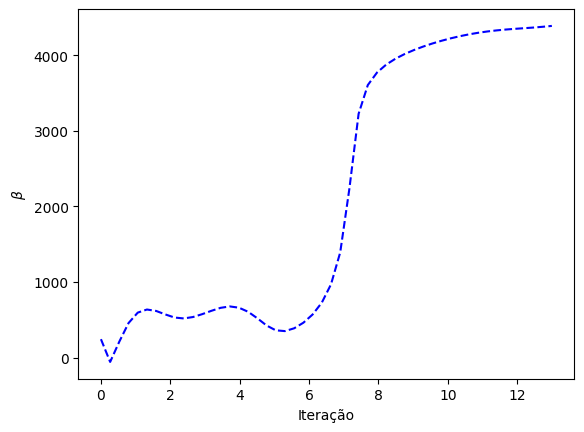

In [12]:
beta_pred = pred[:,3]
plt.plot(test_t, beta_pred, label="Beta previsto", linestyle="--", color="blue")
plt.ylabel(r"$\beta$")
plt.xlabel("Iteração")
plt.show()